#Coursework D

## Parts 1-3

In [1]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras


import matplotlib.style
import matplotlib as mpl

from scipy import linalg

print(tf.__version__)

2.15.0


In [2]:
mnist = keras.datasets.mnist #data set of handwritten numbers
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() #Note each data point/pixl can take a value in range 0-255

print(train_images.shape) #Shape of training images
print(train_labels.shape) #Number of training images
print(test_images.shape) #Shape of testing images
print(test_labels.shape) #Number of testing images

train_images=train_images/255 #normalise data
test_images=test_images/255

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
#Define model
model = keras.models.Sequential() #Add convolution layer and pooling
model.add(keras.layers.Conv2D(28, (5, 6), activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(32, (5, 6), activation='relu')) #added extra convolution layer and pool
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(28, activation='relu'))
model.add(keras.layers.Dense(10))

In [4]:
model.summary() #Sanity check model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 23, 28)        868       
                                                                 
 batch_normalization (Batch  (None, 24, 23, 28)        112       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 11, 28)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 11, 28)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 6, 32)          26912     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 3, 32)          0

In [5]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) #Compiles model with adam optimiser

history = model.fit(train_images, train_labels,batch_size=250,epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
240/240 [==============================] - 7s 8ms/step - loss: 0.3274 - accuracy: 0.8984 - val_loss: 0.7361 - val_accuracy: 0.9665
Epoch 2/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0842 - accuracy: 0.9736 - val_loss: 0.0861 - val_accuracy: 0.9855
Epoch 3/15
240/240 [==============================] - 2s 8ms/step - loss: 0.0598 - accuracy: 0.9812 - val_loss: 0.0368 - val_accuracy: 0.9890
Epoch 4/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.0322 - val_accuracy: 0.9907
Epoch 5/15
240/240 [==============================] - 2s 6ms/step - loss: 0.0403 - accuracy: 0.9874 - val_loss: 0.0291 - val_accuracy: 0.9910
Epoch 6/15
240/240 [==============================] - 2s 9ms/step - loss: 0.0339 - accuracy: 0.9890 - val_loss: 0.0324 - val_accuracy: 0.9893
Epoch 7/15
240/240 [==============================] - 2s 9ms/step - loss: 0.0294 - accuracy: 0.9901 - val_loss: 0.0333 - val_accuracy: 0.9895
Epoch 

In [11]:
#Get PCA comps from training set
print("train_images.shape: ",np.shape(train_images))
#Reshape training set
test_X=np.reshape(train_images,(60000,784))
print("X.shape:",np.shape(test_X))

#Center around mean
mu=np.mean(test_X,axis=0)
train_x=test_X-mu
rho=np.cov(train_x,rowvar=False) # Make the covaraince matrix by np.cov
print("rho.shape:",np.shape(rho))

#Get the eigenvalues and vectors
vals,vecs=linalg.eigh(rho)
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs) #PCA components
vals=np.flip(vals) #Variance of components

train_images.shape:  (60000, 28, 28)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


In [12]:
#Get PC projection on test
# Reshape test images
test_X = np.reshape(test_images, (10000, 784))

# Center data
test_x = test_X - mu

# Project data
test_p = np.dot(test_x, vecs)

In [29]:
#Create a new dataset of test images with varying number of PCs and evaluate model accuracy

N = 784 # Max number of PCs used
PCs = np.arange(0,N+1,10)
test_accuracies1 = []

for i in PCs:
  newImage=(np.dot(test_p[:,0:int(i)],vecs.T[0:int(i),:]))+mu #Creates a new set of images with i PCs
  test_PCA = np.reshape(newImage,[10000,28,28]) # Reshapesinto 28 x 28 images
  _,test_acc = model.evaluate(test_PCA, test_labels)
  test_accuracies1.append(test_acc)


313/313 [==============================] - 1s 3ms/step - loss: 0.0260 - accuracy: 0.9927


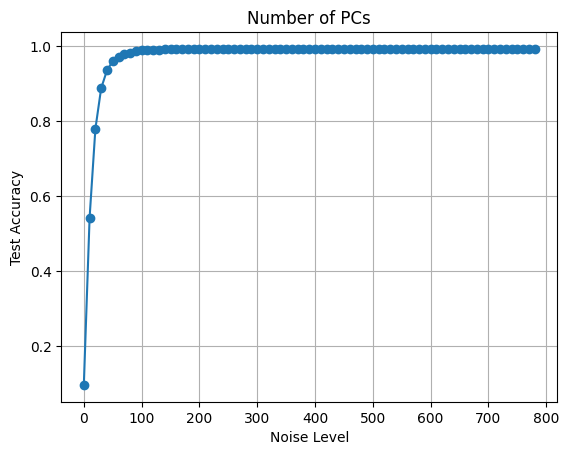

In [30]:
# Plot test accuracy vs PCs
plt.plot(PCs , test_accuracies1, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.title('Number of PCs')
plt.grid(True)
plt.show()

##Parts 4-5

In [13]:
#Make new training data set with 100 best PCs
#Get PC projection on training set
train_p = np.dot(train_x, vecs)
N = 100

newImage=(np.dot(train_p[:,0:N],vecs.T[0:N,:]))+mu #Creates a new set of images with N PCs
train_100PCA = np.reshape(newImage,[60000,28,28]) # Reshapes into 28 x 28 images

In [14]:
#Define model2
model2 = keras.models.Sequential() #Add convolution layer and pooling
model2.add(keras.layers.Conv2D(28, (5, 6), activation='relu', input_shape=(28, 28, 1)))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.MaxPooling2D((2,2)))
model2.add(keras.layers.Dropout(0.1))

model2.add(keras.layers.Conv2D(32, (5, 6), activation='relu')) #added extra convolution layer and pool
model2.add(keras.layers.MaxPooling2D((2, 2)))
model2.add(keras.layers.Dropout(0.2))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(28, activation='relu'))
model2.add(keras.layers.Dense(10))

In [15]:
model2.summary() #Sanity check model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 23, 28)        868       
                                                                 
 batch_normalization_2 (Bat  (None, 24, 23, 28)        112       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 11, 28)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 12, 11, 28)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 6, 32)          26912     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 3, 32)         

In [16]:
#train model with new data set from 100 best PCs

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) #Compiles model with adam optimiser

history = model2.fit(train_100PCA, train_labels,batch_size=250,epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
240/240 [==============================] - 3s 8ms/step - loss: 0.3388 - accuracy: 0.8917 - val_loss: 0.8420 - val_accuracy: 0.9730
Epoch 2/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0893 - accuracy: 0.9726 - val_loss: 0.1084 - val_accuracy: 0.9843
Epoch 3/15
240/240 [==============================] - 2s 6ms/step - loss: 0.0613 - accuracy: 0.9806 - val_loss: 0.0391 - val_accuracy: 0.9876
Epoch 4/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0516 - accuracy: 0.9833 - val_loss: 0.0358 - val_accuracy: 0.9882
Epoch 5/15
240/240 [==============================] - 2s 6ms/step - loss: 0.0451 - accuracy: 0.9859 - val_loss: 0.0346 - val_accuracy: 0.9892
Epoch 6/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.0352 - val_accuracy: 0.9881
Epoch 7/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0363 - accuracy: 0.9884 - val_loss: 0.0297 - val_accuracy: 0.9907
Epoch 

In [17]:
N = 784 # Max number of PCs used
PCs = np.arange(0,N+1,10)
test_accuracies2 = []

for i in PCs:
  newImage=(np.dot(test_p[:,0:int(i)],vecs.T[0:int(i),:]))+mu #Creates a new set of images with i PCs
  test_PCA = np.reshape(newImage,[10000,28,28]) # Reshapes into 28 x 28 images
  _,test_acc = model2.evaluate(test_PCA, test_labels)
  test_accuracies2.append(test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0325 - accuracy: 0.9896


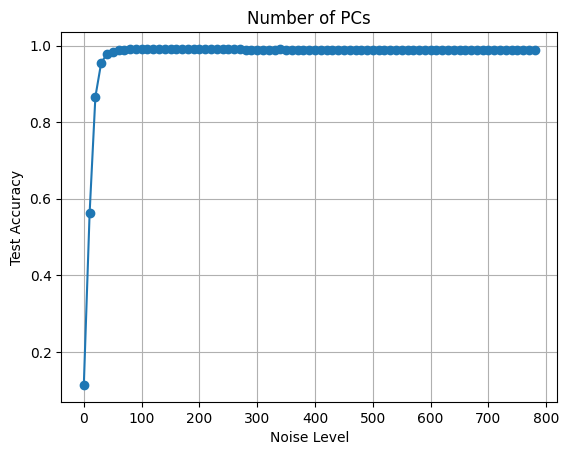

In [18]:
# Plot test accuracy vs noise level
plt.plot(PCs , test_accuracies2, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.title('Number of PCs')
plt.grid(True)
plt.show()

## Part 6

In [19]:
#Make new training data set with 20 best PCs
#Get PC projection on training set
train_p = np.dot(train_x, vecs)
N = 20

newImage=(np.dot(train_p[:,0:N],vecs.T[0:N,:]))+mu #Creates a new set of images with N PCs
train_20PCA = np.reshape(newImage,[60000,28,28]) # Reshapes into 28 x 28 images

In [20]:
#Define model3
model3 = keras.models.Sequential() #Add convolution layer and pooling
model3.add(keras.layers.Conv2D(28, (5, 6), activation='relu', input_shape=(28, 28, 1)))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPooling2D((2,2)))
model3.add(keras.layers.Dropout(0.1))

model3.add(keras.layers.Conv2D(32, (5, 6), activation='relu')) #added extra convolution layer and pool
model3.add(keras.layers.MaxPooling2D((2, 2)))
model3.add(keras.layers.Dropout(0.2))

model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(28, activation='relu'))
model3.add(keras.layers.Dense(10))

In [21]:
model3.summary() #Sanity check model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 23, 28)        868       
                                                                 
 batch_normalization_3 (Bat  (None, 24, 23, 28)        112       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 11, 28)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12, 11, 28)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 6, 32)          26912     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 4, 3, 32)         

In [22]:
#train model with new data set from 20 best PCs

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) #Compiles model with adam optimiser

history = model3.fit(train_20PCA, train_labels,batch_size=250,epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
240/240 [==============================] - 3s 8ms/step - loss: 0.4194 - accuracy: 0.8676 - val_loss: 1.0927 - val_accuracy: 0.8627
Epoch 2/15
240/240 [==============================] - 2s 7ms/step - loss: 0.1634 - accuracy: 0.9492 - val_loss: 0.3833 - val_accuracy: 0.8868
Epoch 3/15
240/240 [==============================] - 2s 6ms/step - loss: 0.1274 - accuracy: 0.9594 - val_loss: 0.1959 - val_accuracy: 0.9359
Epoch 4/15
240/240 [==============================] - 2s 6ms/step - loss: 0.1093 - accuracy: 0.9652 - val_loss: 0.1867 - val_accuracy: 0.9364
Epoch 5/15
240/240 [==============================] - 2s 7ms/step - loss: 0.1016 - accuracy: 0.9681 - val_loss: 0.2195 - val_accuracy: 0.9287
Epoch 6/15
240/240 [==============================] - 2s 8ms/step - loss: 0.0918 - accuracy: 0.9703 - val_loss: 0.2260 - val_accuracy: 0.9264
Epoch 7/15
240/240 [==============================] - 2s 7ms/step - loss: 0.0864 - accuracy: 0.9724 - val_loss: 0.1640 - val_accuracy: 0.9456
Epoch 

In [24]:
N = 784 # Max number of PCs used
PCs = np.arange(0,N+1,10)
test_accuracies3 = []

for i in PCs:
  newImage=(np.dot(test_p[:,0:int(i)],vecs.T[0:int(i),:]))+mu #Creates a new set of images with i PCs
  test_PCA = np.reshape(newImage,[10000,28,28]) # Reshapes into 28 x 28 images
  _,test_acc = model3.evaluate(test_PCA, test_labels)
  test_accuracies3.append(test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.2896 - accuracy: 0.9070


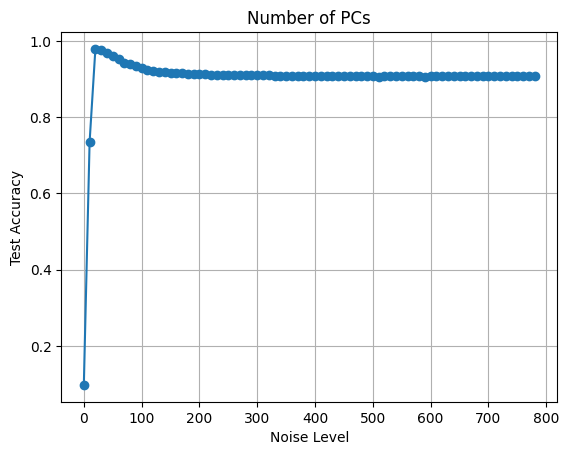

In [25]:
# Plot test accuracy vs noise level
plt.plot(PCs , test_accuracies3, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.title('Number of PCs')
plt.grid(True)
plt.show()